Take in a graph of SNP by SNP and use diagonal to build a graph.

In [174]:
## imports
import numpy as np
from bed_reader import open_bed
import os
from IPython.display import SVG
from sknetwork.embedding import LouvainNE
from sknetwork.visualization import svg_graph, svg_bigraph
from networkx.algorithms import bipartite
from scipy import sparse
from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.hierarchy import cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_bigraph, svg_dendrogram
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import scipy.stats as stats
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.sparse import diags

In [175]:
def get_diagonal(df, width) : # convert SNPxSNP matrix as a result of cramer's to diagonal
    mid = df[df.shape(0)]
    arr = []
    result = np.empty(arr)
    for i in df:
        for j in df.T:
            if abs((i - j)) > width:
                result.append(j)

    return result

In [176]:
## get database workspace
file_name = '/Users/rishasurana/Library/CloudStorage/GoogleDrive-rsurana@usc.edu/.shortcut-targets-by-id/1I-Ssaub3M29w33JyrvO7HVv9laffGidc/chromosome_17_bed_bim_fam_data/ukb22418_c13_b0_v2.bed'
## read bed and select values
bed = open_bed(file_name)
print(bed.shape)
values = bed.read(index=np.s_[0:70,0:70])
print(values.shape)
values = np.array(values)

(488377, 26806)
(70, 70)


SAMPLE build Cramer's correlation matrix
note: Do not use, use SNPcorrelation.ipynb

In [177]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  
  return stat/(obs*mini)

In [178]:
import warnings ## temporarily hide NaN division warnings
warnings.filterwarnings("ignore")

rows= []

for var1 in values:
  col = []
  for var2 in values.T:
    cramers =cramers_V(var1, var2) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results)

Build graph

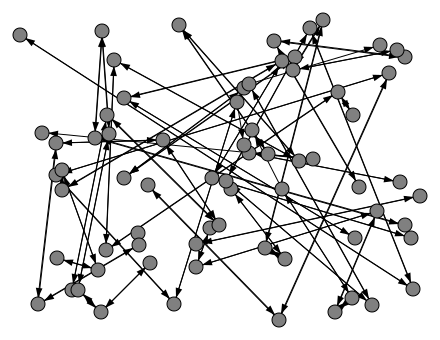

In [186]:
# build graph

offset = 10

dfMatrix = sparse.csr_matrix(df) # convert data frame to a sparse matrix

diagonals = dfMatrix.diagonal(offset) # get x diagonal of matrix

diagArray = diags(diagonals, offset).toarray() # convert diagonal into a square matrix

sparseArrayMatrix = sparse.csr_matrix(diagArray) # convert diagonal to compressed sparse row matrix    

G = nx.Graph(sparseArrayMatrix) # create graph from sparse data

adjacency = nx.adjacency_matrix(G) # create Adjacency matrix

adjacencyMatrix = sparse.csr_matrix(adjacency) # convert back to sparse row matrix form

## train classifier and build graph
louvain = LouvainNE(2)
embedding = louvain.fit_transform(adjacencyMatrix)
image = svg_graph(adjacencyMatrix, position=embedding)
SVG(image)